In [41]:
%reset -f # this is to reset the kernal: clear all in-memory objects

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
test_path  = './Data/test/'
train_path = './Data/train_val/'

make_dir(test_path)
make_dir(train_path)

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

Here we train CNN using simulations from 1 historical and 3 future scenarios. Then we test the trained NN using the ssp245 scenario.

Note that compared to NN, we here shrink the training data size (removing 2 historical scenarios) to avoid kernal dying due to the memory limitation

In [4]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [5]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

y_train = y_train_xr['tas'].data
y_test  = y_test_xr['tas'].data



This is how our predictors & predictand data look like. Our predictors are **1-D** time series of CO2 & CH4.

In [6]:
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


The predictand tas is **2-D** map - this point is different from the NN case

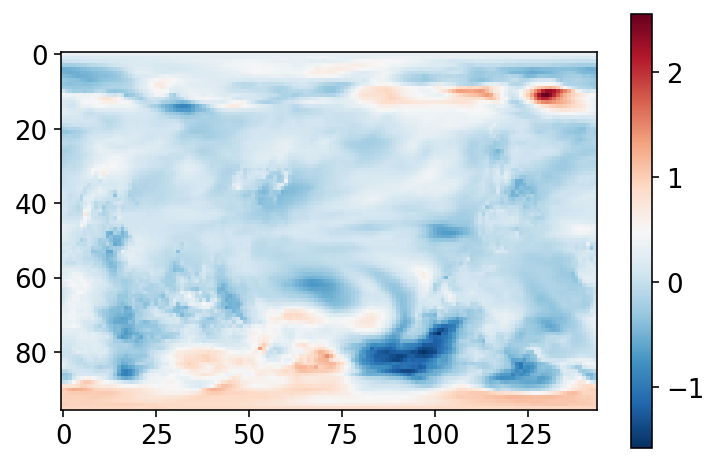

In [10]:
plt.imshow(y_train[0],cmap='RdBu_r')
plt.colorbar()

#### Data normalization

Let's normalize the input predictors by there mean & standard deviation

In [11]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

In [12]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(423, 2) (423, 96, 144) (86, 2) (86, 96, 144)


### 2. Define the CNN architecture


The CNN architecture used here consists of several upsampling blocks. 

We set the dimensions of the hidden layers (i.e., number of neurons) in order to reach the size of the target maps (96x144) in a proportional way (in particular by doubling the dimensions in each upsampling block) through the various upsampling blocks. 

![CNN_structure](https://drive.google.com/uc?export=view&id=18a4aKFf62qWgFZP57HloHKrzHdZpmqjO)

Here are the hyperparameters for the CNN training. Note that these hyperparameters here are for demonstration purposes only and they are not optimized.  

In [13]:
n_filters = 32
weight_initializer = 'glorot_uniform' # glorot uniform is used as weight initializer for each deconvolution layer
alpha_leaky_relu   = 0.01
l1_regularization = 0
l2_regularization = 4e-3
regularizer = l1_l2(l1=l1_regularization, l2=l2_regularization) # base: l1_l2(l1=0.0001, l2=0), 
learning_rate  = 1e-3
minibatch_size = 64
num_epochs     = 200

In [15]:
model = Sequential()

model.add(Dense(n_filters*12*18, input_shape=(X_train.shape[1],), kernel_initializer=weight_initializer))
model.add(LeakyReLU(alpha=alpha_leaky_relu))
model.add(Reshape((12,18,n_filters)))

# Upsample to 24x36
model.add(Conv2DTranspose(filters=n_filters, kernel_regularizer=regularizer, 
                          kernel_initializer=weight_initializer, 
                          kernel_size=(4,4), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=alpha_leaky_relu))

# Upsample to 48x72
model.add(Conv2DTranspose(filters=n_filters, kernel_regularizer=regularizer, 
                          kernel_initializer=weight_initializer, 
                          kernel_size=(4,4), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=alpha_leaky_relu))

# Upsample to 96x144
model.add(Conv2DTranspose(filters=n_filters, kernel_regularizer=regularizer, 
                          kernel_initializer=weight_initializer, 
                          kernel_size=(4,4), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=alpha_leaky_relu))


model.add(Conv2D(filters=1, kernel_size=(5,5), kernel_regularizer=regularizer, 
                 kernel_initializer=weight_initializer, activation='linear', padding='same'))

optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.summary()
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6912)              20736     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6912)              0         
                                                                 
 reshape_1 (Reshape)         (None, 12, 18, 32)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 24, 36, 32)       16416     
 ranspose)                                                       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 36, 32)        0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 48, 72, 32)       16416     
 ranspose)                                            

### 3. Train & save the CNN model


The total training time throughout 200 epochs is **~30min** for 1 CPU

In [23]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/200
6/6 [==============================] - 62s 3s/step - loss: 4.6285 - val_loss: 8.6145
Epoch 2/200
6/6 [==============================] - 17s 3s/step - loss: 4.4344 - val_loss: 8.1113
Epoch 3/200
6/6 [==============================] - 17s 3s/step - loss: 4.0547 - val_loss: 6.7894
Epoch 4/200
6/6 [==============================] - 17s 3s/step - loss: 3.2898 - val_loss: 3.8267
Epoch 5/200
6/6 [==============================] - 17s 3s/step - loss: 2.7250 - val_loss: 3.0892
Epoch 6/200
6/6 [==============================] - 17s 3s/step - loss: 2.0983 - val_loss: 2.4107
Epoch 7/200
6/6 [==============================] - 17s 3s/step - loss: 1.5784 - val_loss: 2.5374
Epoch 8/200
6/6 [==============================] - 17s 3s/step - loss: 1.2404 - val_loss: 1.4527
Epoch 9/200
6/6 [==============================] - 17s 3s/step - loss: 1.0041 - val_loss: 1.4938
Epoch 10/200
6/6 [==============================] - 17s 3s/step - loss: 0.8657 - val_loss: 1.1327
Epoch 11/200
6/6 [===========

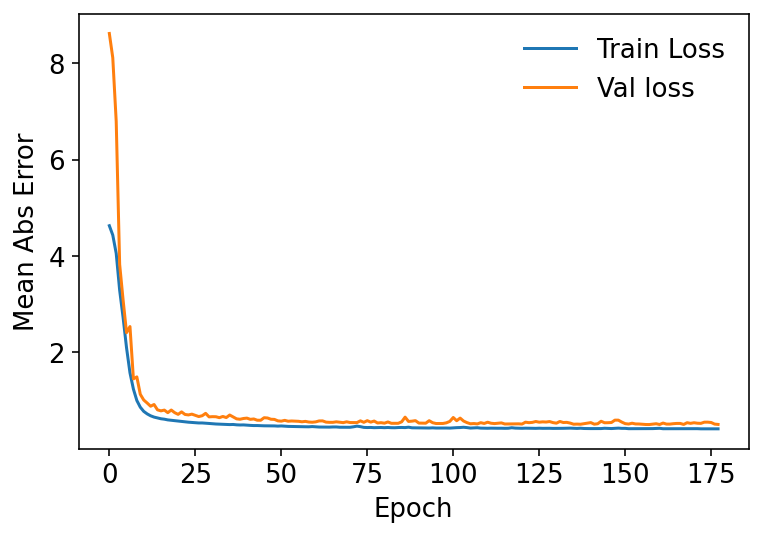

In [24]:
plot_history(history)

In [18]:
model_path = './saved_model/'
make_dir(model_path)

In [27]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(model_path+'CNN_model.h5')

### 4. Evaluate the trained model

In [19]:
# reload the saved model
model = load_model(model_path+'CNN_model.h5')

In [20]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

3/3 [==============================] - 0s 97ms/step


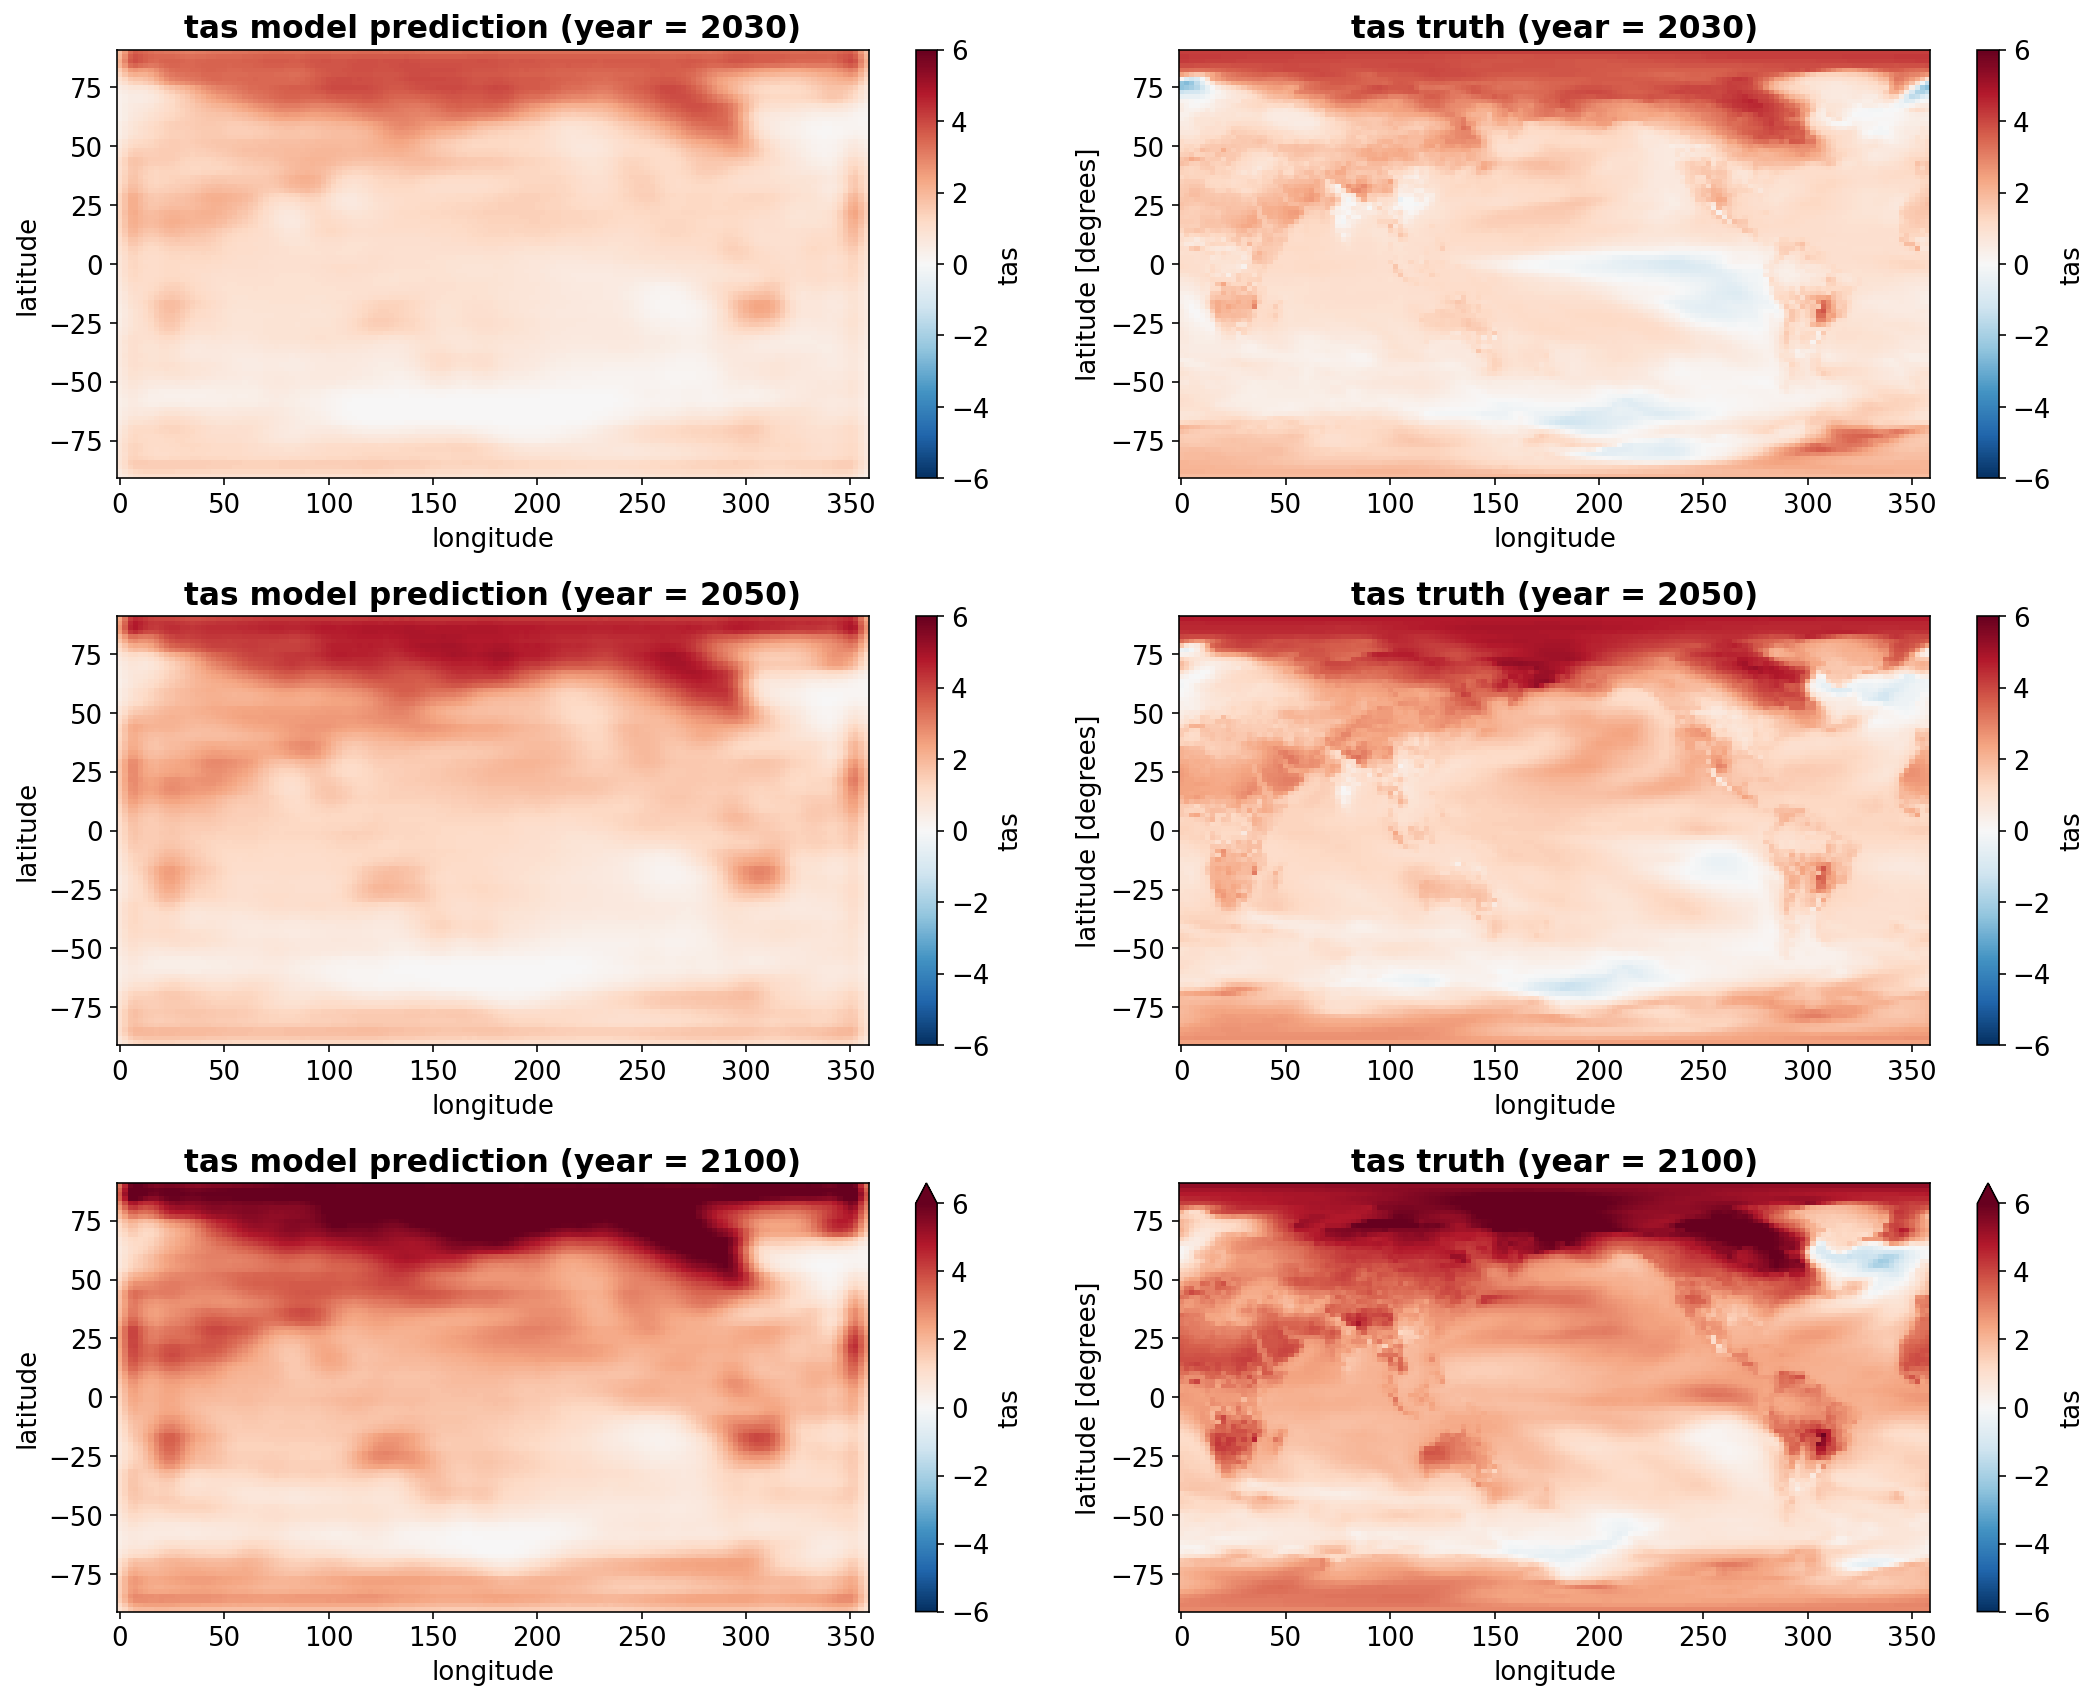

In [21]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()